In [1]:
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
import numpy as np
from sklearn.model_selection import train_test_split
import seaborn as sns

%matplotlib inline

In [2]:
data = pd.read_csv('big_mart_train.csv')

In [3]:
data.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [4]:
#item identifier isn't useful in this context
data = data.drop('Item_Identifier', axis='columns')

In [5]:
#encode non_numeric types to their own column with binary values
data_encoded = pd.get_dummies(data)

In [6]:
data_encoded.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,...,Outlet_Size_High,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3
0,9.30,0.016047,249.8092,1999,3735.1380,0,1,0,0,0,...,0,1,0,1,0,0,0,1,0,0
1,5.92,0.019278,48.2692,2009,443.4228,0,0,1,0,0,...,0,1,0,0,0,1,0,0,1,0
2,17.50,0.016760,141.6180,1999,2097.2700,0,1,0,0,0,...,0,1,0,1,0,0,0,1,0,0
3,19.20,0.000000,182.0950,1998,732.3800,0,0,1,0,0,...,0,0,0,0,0,1,1,0,0,0
4,8.93,0.000000,53.8614,1987,994.7052,0,1,0,0,0,...,1,0,0,0,0,1,0,1,0,0


In [7]:
data_label = data_encoded.pop('Item_Outlet_Sales')

In [8]:
#add the label to the end of the DF
data_encoded['Item_Outlet_Sales'] = data_label

In [9]:
#the sales we will use for the label is now moved to a different DF
data_encoded.head()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Fat_Content_LF,Item_Fat_Content_Low Fat,Item_Fat_Content_Regular,Item_Fat_Content_low fat,Item_Fat_Content_reg,Item_Type_Baking Goods,...,Outlet_Size_Medium,Outlet_Size_Small,Outlet_Location_Type_Tier 1,Outlet_Location_Type_Tier 2,Outlet_Location_Type_Tier 3,Outlet_Type_Grocery Store,Outlet_Type_Supermarket Type1,Outlet_Type_Supermarket Type2,Outlet_Type_Supermarket Type3,Item_Outlet_Sales
0,9.30,0.016047,249.8092,1999,0,1,0,0,0,0,...,1,0,1,0,0,0,1,0,0,3735.1380
1,5.92,0.019278,48.2692,2009,0,0,1,0,0,0,...,1,0,0,0,1,0,0,1,0,443.4228
2,17.50,0.016760,141.6180,1999,0,1,0,0,0,0,...,1,0,1,0,0,0,1,0,0,2097.2700
3,19.20,0.000000,182.0950,1998,0,0,1,0,0,0,...,0,0,0,0,1,1,0,0,0,732.3800
4,8.93,0.000000,53.8614,1987,0,1,0,0,0,0,...,0,0,0,0,1,0,1,0,0,994.7052


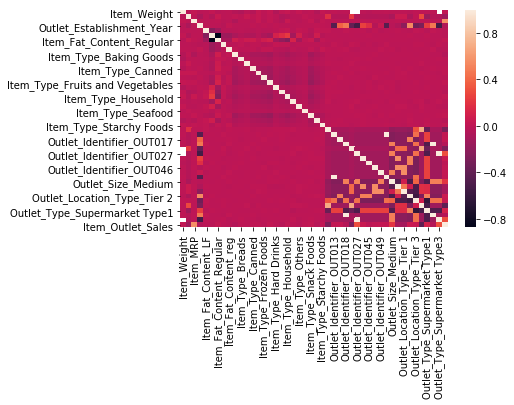

In [10]:
corr = data_encoded.corr()
sns.heatmap(corr)

In [11]:
X, y = data_encoded.iloc[:,:-1],data.iloc[:,-1]

In [12]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [13]:
seed = 7
test_size = 0.33
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [14]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear')

In [15]:
xg_reg.fit(x_train,y_train)

preds = xg_reg.predict(x_test)

In [16]:
xg_reg.score(x_test,y_test)

0.5813310566286877

In [17]:
#####

In [18]:
data_encoded.columns

Index(['Item_Weight', 'Item_Visibility', 'Item_MRP',
       'Outlet_Establishment_Year', 'Item_Fat_Content_LF',
       'Item_Fat_Content_Low Fat', 'Item_Fat_Content_Regular',
       'Item_Fat_Content_low fat', 'Item_Fat_Content_reg',
       'Item_Type_Baking Goods', 'Item_Type_Breads', 'Item_Type_Breakfast',
       'Item_Type_Canned', 'Item_Type_Dairy', 'Item_Type_Frozen Foods',
       'Item_Type_Fruits and Vegetables', 'Item_Type_Hard Drinks',
       'Item_Type_Health and Hygiene', 'Item_Type_Household', 'Item_Type_Meat',
       'Item_Type_Others', 'Item_Type_Seafood', 'Item_Type_Snack Foods',
       'Item_Type_Soft Drinks', 'Item_Type_Starchy Foods',
       'Outlet_Identifier_OUT010', 'Outlet_Identifier_OUT013',
       'Outlet_Identifier_OUT017', 'Outlet_Identifier_OUT018',
       'Outlet_Identifier_OUT019', 'Outlet_Identifier_OUT027',
       'Outlet_Identifier_OUT035', 'Outlet_Identifier_OUT045',
       'Outlet_Identifier_OUT046', 'Outlet_Identifier_OUT049',
       'Outlet_Size_High

In [19]:
data_encoded = data_encoded.drop(
                                ['Outlet_Location_Type_Tier 1',
                                'Outlet_Location_Type_Tier 2',
                                'Outlet_Location_Type_Tier 3',
                                'Outlet_Type_Grocery Store',
                                'Outlet_Type_Supermarket Type1',
                                'Outlet_Type_Supermarket Type2',
                                'Outlet_Type_Supermarket Type3'],
                                axis='columns')

In [20]:
X, y = data_encoded.iloc[:,:-1],data.iloc[:,-1]

In [21]:
data_dmatrix = xgb.DMatrix(data=X,label=y)

In [22]:
seed = 7
test_size = 0.33
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

In [23]:
xg_reg = xgb.XGBRegressor(objective ='reg:linear')

In [24]:
xg_reg.fit(x_train,y_train)

preds = xg_reg.predict(x_test)

In [25]:
xg_reg.score(x_test,y_test)

0.5812950834212676

---
To verify the score method for a linear regression problem is in fact returning the R-Squared value, we can use r2_score

In [41]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from numpy import sqrt

In [42]:
# they do appear to match the xgb.score method
r2_score(y_test, preds)

0.5812950834212676

In [44]:
mean_squared_error(y_test, preds)

1240175.1696467053

In [40]:
sqrt(mean_squared_error(y_test, preds))

1113.6315232816935